# Code to run LSTM-CNN GAN

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/c147_project/')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import time
from data import eegData
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
# get the device type of machine
train_dataset = eegData('data/X_train_valid.npy', 'data/y_train_valid.npy', device, preprocessing_params={'subsample':6, 'trim':400})

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import time
import numpy as np
import matplotlib.pyplot as plt
!pip install torchinfo --quiet
import torchinfo

def count_parameters(model):
  """Function for count model's parameters"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Reshape(nn.Module):
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape
  
  def forward(self, x):
    new_shape = [x.shape[0]] + list(self.shape)
    return x.view(new_shape)

class LSTMGenerator(nn.Module):
  """
  Generator that uses LSTM layer
  input is (batch, in_dim, seq)
  output is (batch, out_dim, seq)
  """
  def __init__(self, input_dim, hidden_dim, output_dim=22, n_layers=1, bias=False):
    super(LSTMGenerator, self).__init__()
    self.input_dim = input_dim
    self.out_dim = output_dim
    self.hidden_dim = hidden_dim
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, bias=bias, batch_first=True)

    self.linear = nn.Sequential(
        nn.Linear(hidden_dim, output_dim),
        nn.Tanh()
    )


  def forward(self, x):
    d1, d2, d3 = x.shape 
    x_reshaped = x.view(d1, d3, d2)
    recurrent, hidden = self.lstm(x_reshaped)
    out = self.linear(recurrent.contiguous().view(d1 * d3, self.hidden_dim))
    return out.view(d1, self.out_dim, d3)


In [ ]:
class CNNDiscriminator(nn.Module):
  """
  Discriminator that uses CNN layers
  follows the DCGAN of the pytorch tutorial
  https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
  input is (batch, in_dim, seq)
  output is (batch, 1, seq)
  """
  def __init__(self, input_dim, hidden_dims):
    super(CNNDiscriminator, self).__init__()
    assert len(hidden_dims) == 4
    self.conv1 = nn.Sequential(
        nn.Conv1d(input_dim, hidden_dims[0], 3, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True)
    ) # output batch x dim1 x 50
    self.conv2 = nn.Sequential(
        nn.Conv1d(hidden_dims[0], hidden_dims[1], 3, 2, 1, bias=False),
        nn.BatchNorm1d(hidden_dims[1]),
        nn.LeakyReLU(0.2, inplace=True),
    ) # ouptut batch x dim2 x 25
    self.conv3 = nn.Sequential(
        nn.Conv1d(hidden_dims[1], hidden_dims[2], 3, 2, 1, bias=False),
        nn.BatchNorm1d(hidden_dims[2]),
        nn.LeakyReLU(0.2, inplace=True),
    )# ouptut batch x dim3 x 13

    self.conv4 = nn.Sequential(
        nn.Conv1d(hidden_dims[2], hidden_dims[3], 3, 2, 1, bias=False),
        nn.BatchNorm1d(hidden_dims[3]),
        nn.LeakyReLU(0.2, inplace=True),
    )# ouptut batch x dim3 x 7

    self.end = nn.Sequential(
        nn.Conv1d(hidden_dims[3], 1, 3, 2, 1, bias=False),
        nn.BatchNorm1d(1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv1d(1, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )



  def forward(self, x):
    return self.end(self.conv4(self.conv3(self.conv2(self.conv1(x)))))

In [ ]:
class GAN(object):
  """
  Class object to control and abstract the training and logging of vanilla GANs
  Assumes that the noise input or z vector is (batch_size, 2, 600) 
    where the first channel is noise and the second channel is the label
  """
  def __init__(self,
               generator: nn.Module,
               discriminator: nn.Module,
               train_valid_data,
               **kwargs
               ):
    self.G = generator
    self.D = discriminator
    self.loss = nn.BCELoss()
    self.dataset = train_valid_data
    # checking for CUDA acceleration
    # move parameters to Cuda
    # establish before the optimizer and loss
    self.cuda_bool = kwargs.get('cuda', False)
    self.cuda_device = kwargs.get('device', 0)
    self.device = torch.device('cpu')
    if self.cuda_bool:
      print("Establishing network on CUDA device: ", torch.cuda.get_device_name(self.cuda_device))
      self.device = torch.device('cuda')
      self.G.cuda(self.cuda_device)
      self.D.cuda(self.cuda_device)
      self.loss.cuda(self.cuda_device)
    
    # setting up optimizers
    lr = kwargs.get('learn_rate', 0.0002)
    w_decay = kwargs.get('weight_decay', 0.00001)
    self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=lr, weight_decay=w_decay)
    self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=lr, weight_decay=w_decay)


  def train(self, 
            epochs, batch_size, save_path, verbose=True, print_every=100):
    
    
    self.epochs = epochs

    self.batch_size = batch_size

    self.G_loss = list()
    self.D_loss = list()
    self.generated_test = list()

    # setup the loader
    data_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

    iteration = 0

    # TODO: change the input
    fixed_z = torch.rand((1, self.G.input_dim - 1, 100), device=self.device)
    fixed_labels = torch.zeros((1 , 1), device=self.device).reshape(-1, 1).repeat(1, 100).reshape(-1, 1, 100)
    fixed_z = torch.cat([fixed_z, fixed_labels], dim=1).to(self.device)
    real_label = 1
    fake_label = 0
    for epoch in range(self.epochs + 1):
      for i, sample in enumerate(data_loader):
        # What to do for each batch

        if i == data_loader.dataset.__len__() // self.batch_size:
          break

        self.G.train()

        # assert data and labels
        eeg_data = sample['data']
        eeg_labels = sample['label']

        # input vector for 
        noise = torch.rand((self.batch_size, self.G.input_dim - 1, 100), device=self.device)
        labels = eeg_labels.reshape(-1, 1).repeat(1, 100).reshape(-1, 1, 100)
        
        z = torch.cat([noise, labels], dim=1)

        seq_length = eeg_data.shape[2]

        benchmark = torch.full((self.batch_size, 1, 1), real_label, device=self.device, dtype=torch.float)

        # attach to cuda
        if self.cuda_bool:
          eeg_data = Variable(eeg_data.cuda(self.cuda_device))
          z = Variable(z.cuda(self.cuda_device))
        else:
          eeg_data = Variable(eeg_data)
          z = Variable(z)
        

        ##############
        # Training the Discriminator
        ##############
        self.d_optimizer.zero_grad()
        self.D.zero_grad() # remove previous gradients
        # train the discriminator on real data
        real_score = self.D(eeg_data)
        d_loss_real = self.loss(real_score, benchmark)
        d_loss_real.backward()
        real_output_score = real_score.mean().item()

        # train the discriminator on fake data

        benchmark.fill_(fake_label)
        fake_data = self.G(z)
        fake_score = self.D(fake_data.detach())
        d_loss_fake = self.loss(fake_score, benchmark)
        d_loss_fake.backward()
        # print(fake_score)
        G_output_score1 = fake_score.mean().item()
        

        # optimize the discriminator
        d_loss = d_loss_real + d_loss_fake
        self.d_optimizer.step()


        ##############
        # Training the Generator
        ##############
        self.G.zero_grad() # remove previous gradients
        self.g_optimizer.zero_grad()

        benchmark.fill_(real_label)
        fake_score2 = self.D(fake_data)
        G_output_score2 = fake_score2.mean().item()
        g_loss = self.loss(fake_score2, benchmark)
        g_loss.backward()
        self.g_optimizer.step()

        iteration += 1
        
        if iteration % print_every == 0 and verbose:
          # output the loss and the scores
          print("Iteration : ", iteration)
          print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tReal Score: %.4f\t Fake Scores: %.4f / %.4f'
                  % (epoch, self.epochs, i, len(data_loader),
                     d_loss.item(), g_loss.item(), real_output_score, G_output_score1, G_output_score2))
          
        self.G_loss.append(g_loss.cpu().item())
        self.D_loss.append(d_loss.cpu().item())

      # check how the Generator is doing
      with torch.no_grad() :
        self.G.eval()
        fake_data = self.G(fixed_z).detach().cpu()
        self.generated_test.append(np.mean(fake_data.numpy(), axis=(0, 1)))


      if epoch % 500 == 0:
        save_str = save_path + '/Generator_' + str(epoch) + '.pth'
        self.save_models(save_str)


  def save_models(self, path):
    torch.save(self.G.state_dict(), path)
    print("Saved generator at " + path)
    return True

In [ ]:
Gtest = LSTMGenerator(4, 44)
Dtest = CNNDiscriminator(22, [18, 14, 10 , 6])
toy_GAN = GAN(Gtest, Dtest, train_dataset, cuda=True)

In [ ]:
toy_GAN.train(5000, 250, save_path='/content/drive/My Drive/c147_project/Models/LSTM-CNN')

Streaming output truncated to the last 5000 lines.
Iteration :  600
[11/5000][49/51]	Loss_D: 0.5603	Loss_G: 1.5831	Real Score: 0.7277	 Fake Scores: 0.2124 / 0.2091
Iteration :  700
[13/5000][49/51]	Loss_D: 0.4971	Loss_G: 1.7193	Real Score: 0.7469	 Fake Scores: 0.1839 / 0.1815
Iteration :  800
[15/5000][49/51]	Loss_D: 0.6320	Loss_G: 1.4907	Real Score: 0.7345	 Fake Scores: 0.2626 / 0.2381
Iteration :  900
[17/5000][49/51]	Loss_D: 0.5086	Loss_G: 1.6647	Real Score: 0.7474	 Fake Scores: 0.1917 / 0.1904
Iteration :  1000
[19/5000][49/51]	Loss_D: 0.5737	Loss_G: 1.5629	Real Score: 0.7696	 Fake Scores: 0.2549 / 0.2394
Iteration :  1100
[21/5000][49/51]	Loss_D: 0.4580	Loss_G: 1.7521	Real Score: 0.7851	 Fake Scores: 0.1896 / 0.1839
Iteration :  1200
[23/5000][49/51]	Loss_D: 0.3661	Loss_G: 2.0446	Real Score: 0.8019	 Fake Scores: 0.1334 / 0.1322
Iteration :  1300
[25/5000][49/51]	Loss_D: 0.3171	Loss_G: 2.2094	Real Score: 0.8200	 Fake Scores: 0.1110 / 0.1108
Iteration :  1400
[27/5000][49/51]	Loss_D

Text(0.5, 1.0, 'LSTM-CNN GAN loss diagram')

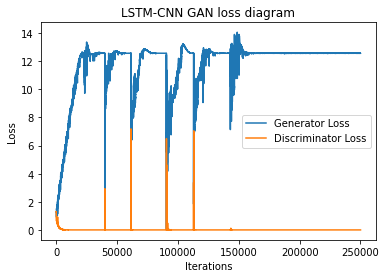

In [ ]:
plt.plot(toy_GAN.G_loss, label='Generator Loss')
plt.plot(toy_GAN.D_loss, label='Discriminator Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM-CNN GAN loss diagram")

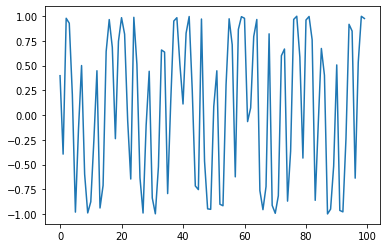

In [ ]:
plt.plot(toy_GAN.generated_test[-1])

In [ ]:
import torchinfo
# to run please add the hidden variable to the output of the generator
batch = 250
Gtest.to(device)
print(torchinfo.summary(Gtest, input_size=(250, 4, 100)))

Dtest.to(device)
print(torchinfo.summary(Dtest, input_size=(250, 22, 100)))




Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [250, 100, 44]            8,448
├─Sequential: 1-2                        [25000, 22]               --
|    └─Linear: 2-1                       [25000, 22]               990
|    └─Tanh: 2-2                         [25000, 22]               --
Total params: 9,438
Trainable params: 9,438
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.40
Forward/backward pass size (MB): 13.20
Params size (MB): 0.04
Estimated Total Size (MB): 13.64
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [250, 18, 50]             --
|    └─Conv1d: 2-1                       [250, 18, 50]             1,188
|    └─LeakyReLU: 2-2                    [250, 18, 50]             --
├─Sequential: 1-2                        [250, 14, 25]             --
|    └─Conv1d: 2-3                       [250, 14, 25]             756
|